# **Entrega Final para Instancia Evaluativa Final: Machine Learning**

### ***Hecho por Elizabeth Granda, 1000900741***

### **[Link de la presentación final](https://www.canva.com/design/DAGW-89Taz4/MGY-vM0yx48RKxoU-NP3kw/edit)**

Para esta segunda entrega se adjunta el modelo realizado. En este notebook se presentan tres modelos que dieron los mejores resultados observando métricas como recall y precision pero destacando principalmente los resultados brindados por la matriz de confusión y la gráfica de probabilidades. Para el despliegue del modelo se usa finalmente uno solo.

El despliegue del modelo se realizará en otro notebook llamado `FinalExam_Deploy.ipynb` ya que al ponerlo acá creo que quedaría muy cargado este cuaderno de código.

---




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import mutual_info_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix

In [2]:
data = pd.read_csv("TechnicalInterviewFraudPrevention.csv")
data

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.000,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,7.25,37.51,1
1,0,10,29014.0,0,0,0.000,0.0,0,0,UY,...,0,1,1,0,3,0.00,0.00,11.66,8.18,1
2,0,7,92.0,0,1,0.000,0.0,0,1,UY,...,0,3,1,0,2,0.00,0.00,86.97,13.96,1
3,9,16,50269.0,0,0,0.000,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,2.51,93.67,1
4,0,8,8180.0,0,0,0.000,0.0,0,0,UY,...,0,1,1,0,1,0.00,0.00,25.96,135.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,0,3,63302.0,0,1,0.500,0.0,0,0,BR,...,1,1,1,0,1,0.00,0.00,85.73,132.17,1
16876,0,12,825.0,0,0,0.000,0.0,0,0,BR,...,1,1,1,0,5,0.00,0.00,12.50,26.34,1
16877,1,3,81067.0,0,0,0.000,0.0,0,0,BR,...,0,1,1,0,1,0.00,0.00,24.16,195.63,1
16878,0,9,398372.0,0,0,0.000,0.0,0,0,BR,...,0,2,1,0,1,0.00,0.00,29.00,36.97,1


In [3]:
data.columns=data.columns.str.strip().str.lower().str.replace(" ", "_")
string_type_cols = data.dtypes[data.dtypes == "object"].index.tolist()
for col in string_type_cols:
  data[col] = data[col].str.strip().str.lower().str.replace(" ", "_")

In [4]:
object_columns = ["r", "monto", "q"]
for col in object_columns:
    data[col] = data[col].str.replace(',', '').astype(float)

## **Empezando el modelo**

Antes de dividir nuestra data eliminaremos la o las columnas que no usaremos en el modelo por facilidades del código.

Como observamos en el EDA inicialmente, la variable `k` tiene $12864$ valores nulos, lo que es más del $80 \%$ de los valores totales del dataset. Esto nos indica que K en realidad no tiene mucha relación para determinar lo que es fraude o no. Por lo que descartaremos esta feature. La feature `c` también tiene varios nulos pero no tanto como `k` ($3197$) por lo que haremos será observar su distribución y mirar si podemos llenar esos valores con la media:


<Axes: xlabel='c', ylabel='Count'>

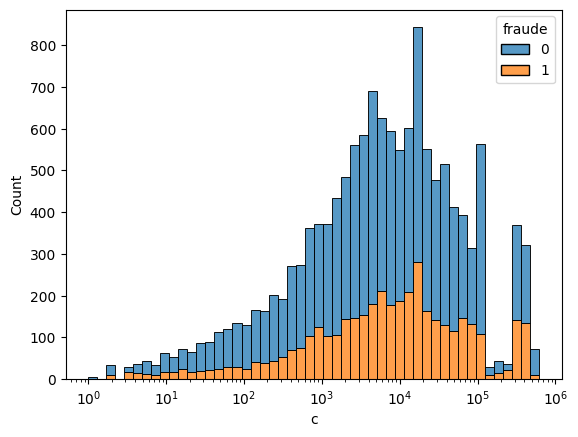

In [5]:
sns.histplot(data=data, x='c', bins=50, hue='fraude', multiple='stack', log_scale=True)

Como vemos tiene una distribución parecida a la normal, lo que nos permite rellenar estos valores nulos de esta forma. Realizando ambas operaciones nos queda que:

In [6]:
#data.drop(columns=['k'], inplace=True)
data.c.fillna(data.c.mean(), inplace=True)

<ipython-input-6-5324fcc2f0ba>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.c.fillna(data.c.mean(), inplace=True)


Ahora sí lo primero que haremos para empezar nuestro modelo será dividir la data en `train, val, test`. Esto es:

In [7]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
len(df_train), len(df_val), len(df_test)

(10128, 3376, 3376)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
y_train = df_train.fraude.values
y_val = df_val.fraude.values
y_test = df_test.fraude.values

del df_train['fraude']
del df_val['fraude']
del df_test['fraude']

In [11]:
df_full_train = df_full_train.reset_index(drop=True)

In [12]:
df_full_train.head()

,a,b,c,d,e,f,g,h,i,j,...,l,m,n,o,p,q,r,s,monto,fraude
0,0,3,13005.000000,0,0,0.000,0.0,0,0,ar,...,0,1,1,0,1,0.0,0.0,14.13,36.01,0
1,0,16,388.000000,0,0,0.000,0.0,0,0,ar,...,0,1,1,0,2,0.0,0.0,49.02,22.67,1
2,0,6,39235.339984,0,0,0.000,0.0,0,0,ar,...,0,1,1,0,1,0.0,0.0,15.66,200.12,1
3,0,11,79933.000000,0,4,0.667,0.0,0,0,ar,...,0,2,1,0,1,0.0,0.0,9.43,51.82,0
4,0,1,6.000000,0,0,0.000,0.0,0,0,br,...,0,1,1,0,1,0.0,0.0,18.04,1682.98,0


Teniendo en cuenta que no hay mucho contexto de lo que es o no es cada variable, normalizaremos la data para no incurrir en errores.

In [13]:
def Normalize_Data(df):
  numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
  scaler = StandardScaler()
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
  return df

In [14]:
%%capture
df_full_train_ = df_full_train.copy()
del df_full_train_["fraude"]
Normalize_Data(df_full_train_)
Normalize_Data(df_train)
Normalize_Data(df_val)
Normalize_Data(df_test)

In [15]:
df_train.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,monto
0,0.650469,-0.136979,-0.003576,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,ar,NaN,-0.649296,-0.536118,-0.227047,-0.078623,-0.566837,-0.112333,-0.053889,-0.567837,0.212727
1,-0.281480,-0.991636,-0.458830,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,ar,NaN,-0.649296,0.453278,-0.227047,-0.078623,-0.566837,-0.112333,-0.053889,-0.389905,0.969941
2,-0.281480,-0.564307,0.059592,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,ar,NaN,0.855181,-0.536118,-0.227047,-0.078623,-0.566837,-0.112333,-0.053889,-0.710705,-0.527964
3,-0.281480,0.717678,-0.475107,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,mx,NaN,-0.649296,-0.536118,-0.227047,-0.078623,-0.566837,-0.112333,-0.053889,-0.920717,-0.323999
4,1.582419,-1.205300,0.792355,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,br,NaN,0.855181,0.453278,2.275168,-0.078623,-0.566837,-0.112333,-0.053889,-0.333951,0.025178


In [16]:
# creamos una nueva columna para cabin
df_train['k_bin'] = np.where(df_train['k'].isna(), 0, 1)
df_full_train['k_bin'] = np.where(df_full_train['k'].isna(), 0, 1)
df_test['k_bin'] = np.where(df_test['k'].isna(), 0, 1)
df_val['k_bin'] = np.where(df_val['k'].isna(), 0, 1)

# eliminamos cabin
del df_train['k']
del df_full_train['k']
del df_test['k']
del df_val['k']

Ahora con nuestra data normalizada y sin datos nulos, realizaremos un `mutual_information_score` para observar qué tanto se relacionan las features que tenemos con el target `fraude`. Esto es:

In [17]:
numerical_type_cols = df_full_train.select_dtypes(include=['float64', 'int64'])
del numerical_type_cols["fraude"]
string_type_cols = df_full_train.select_dtypes(include=['object'])

In [18]:
def mutual_info_fraude_score(series):
    return mutual_info_score(series, df_full_train.fraude)

In [19]:
# Mutual information oara variables categoricas
mutual_info_obj = df_full_train[string_type_cols.columns].apply(mutual_info_fraude_score)
mutual_info_obj.sort_values(ascending=False)

,0
j,0.056165


El árbol de decisión nos dice entonces que la variable `b` es la característica que proporciona la mejor división inicial de los datos. Recordemos que un índice de Gini bajo indica que el nodo es más puro, es decir, que la mayoría de los datos en ese nodo pertenecen a una misma clase. Esto significa que en las features `b, s, q` los valores de lo que es fraude y no es fraude está distinguido de mejor forma.

Esto coincide un poco con lo que nos da el mutual information si observamos sus primeros 5 valores.

---

Hasta ahora hemos mirado la relación de las variables numéricas con el target `fraude`, sin embargo es importante recordar que tenemos una variable categórica `j` que nos indica el país de la transacción y creo que puede influir bastante en el modelo.

Debido a que esta variable tiene bastantes categorías ($19$) realizar One Hot Encoding no sería una buena idea ya que estaríamos agregando demasiadas columnas al modelo lo que podría añadir ruido, por lo que agruparemos las variables de una forma particular. Para describirla primero observemos un `value_counts()` de la varriable para mirar cuántas veces aparecen sus categorías:

In [20]:
data.j.value_counts()

,count
j,
ar,9329
br,4428
mx,2366
es,314
us,230
uy,180
ca,12
gb,8
gt,2


Como vemos, hay $13$ países con menos de $20$ apariciones en todo el dataset, entonces lo que haremos será crear un grupo para estos países, al cual le asignaremos el nombre de grupo $1$. Para los países que aparecen (tienen una frecuencia) de 100 a 350 veces, formaremos otro grupo que llamaremos grupo $2$. Por ultimo, para los países que aprecen entre $1000$ y $9400$ veces, formaremos otro grupo que llamaremos grupo $3$.

Esto es:

In [21]:
country_counts = data['j'].value_counts()

def assign_country_groups(df, country_counts):
    def assign_group(country):
        count = country_counts.get(country, 0)
        if count < 20:
            return 1
        elif 100 <= count < 350:
            return 2
        elif 1000 <= count <= 9400:
            return 3
        else:
            return 'otro'

    df['country_group'] = df['j'].apply(assign_group)

assign_country_groups(df_full_train, country_counts)
assign_country_groups(df_train, country_counts)
assign_country_groups(df_val, country_counts)
assign_country_groups(df_test, country_counts)

In [22]:
df_test.head()

,a,b,c,d,e,f,g,h,i,j,...,m,n,o,p,q,r,s,monto,k_bin,country_group
0,-0.266744,-0.982104,-0.384183,-0.10923,-0.278383,-0.171987,-0.084013,-0.087644,-0.187039,br,...,-0.522426,-0.220034,-0.079745,-0.587049,-0.100308,-0.055241,-0.108859,0.201194,0,3
1,-0.266744,-0.344900,-0.435727,-0.10923,-0.278383,-0.171987,-0.084013,-0.087644,-0.187039,ar,...,-0.522426,-0.220034,-0.079745,-0.587049,-0.100308,-0.055241,0.393205,-0.335041,0,3
2,-0.266744,-1.194505,-0.455980,-0.10923,-0.278383,-0.171987,-0.084013,-0.087644,-0.187039,mx,...,-0.522426,-0.220034,-0.079745,1.295970,-0.100308,-0.055241,-1.008487,-0.517080,1,3
3,-0.266744,-0.344900,-0.303896,-0.10923,-0.278383,-0.171987,-0.084013,-0.087644,-0.187039,mx,...,-0.522426,-0.220034,-0.079745,-0.587049,-0.100308,-0.055241,-0.295494,-0.032378,0,3
4,-0.266744,-1.406906,-0.420693,-0.10923,-0.278383,-0.171987,-0.084013,-0.087644,-0.187039,mx,...,-0.522426,-0.220034,-0.079745,-0.587049,-0.100308,-0.055241,-0.724678,2.804461,0,3


In [23]:
df_full_train.country_group.value_counts()

,count
country_group,
3,12907
2,572
1,25


Ahora, teniendo únicamente 3 grupos, sí es óptimo realizar OneHotEncoding! Esto es:

In [24]:
encoder = OneHotEncoder(drop=None, sparse_output=False)
def onehot_encode_grupo(df):
    grupo_encoded = encoder.fit_transform(df[['country_group']])
    group_labels = encoder.get_feature_names_out(['country_group'])
    grupo_df = pd.DataFrame(grupo_encoded, columns=group_labels, index=df.index)
    df.drop(columns=['country_group'], inplace=True)
    df = pd.concat([df, grupo_df], axis=1)

    return df

df_full_train = onehot_encode_grupo(df_full_train)
df_train = onehot_encode_grupo(df_train)
df_val = onehot_encode_grupo(df_val)
df_test = onehot_encode_grupo(df_test)

In [25]:
df_train.head()

,a,b,c,d,e,f,g,h,i,j,...,o,p,q,r,s,monto,k_bin,country_group_1,country_group_2,country_group_3
0,0.650469,-0.136979,-0.003576,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,ar,...,-0.078623,-0.566837,-0.112333,-0.053889,-0.567837,0.212727,0,0.0,0.0,1.0
1,-0.281480,-0.991636,-0.458830,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,ar,...,-0.078623,-0.566837,-0.112333,-0.053889,-0.389905,0.969941,0,0.0,0.0,1.0
2,-0.281480,-0.564307,0.059592,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,ar,...,-0.078623,-0.566837,-0.112333,-0.053889,-0.710705,-0.527964,0,0.0,0.0,1.0
3,-0.281480,0.717678,-0.475107,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,mx,...,-0.078623,-0.566837,-0.112333,-0.053889,-0.920717,-0.323999,0,0.0,0.0,1.0
4,1.582419,-1.205300,0.792355,-0.089058,-0.288383,-0.157313,-0.087517,-0.101924,-0.169734,br,...,-0.078623,-0.566837,-0.112333,-0.053889,-0.333951,0.025178,0,0.0,0.0,1.0


Muy bien ahora ¿Qué pasa si intentamos ver cómo queda el mutual information y el árbol de decisión con el país codificado?

In [26]:
#decision tree
predictors = df_full_train.columns.to_list()
predictors.remove('fraude')
predictors.remove('j')

target = df_full_train['fraude']

tree = DecisionTreeClassifier(criterion='gini', min_samples_split=20, max_depth=4, random_state=99)
tree.fit(df_full_train[predictors], target)

DecisionTreeClassifier(max_depth=4, min_samples_split=20, random_state=99)

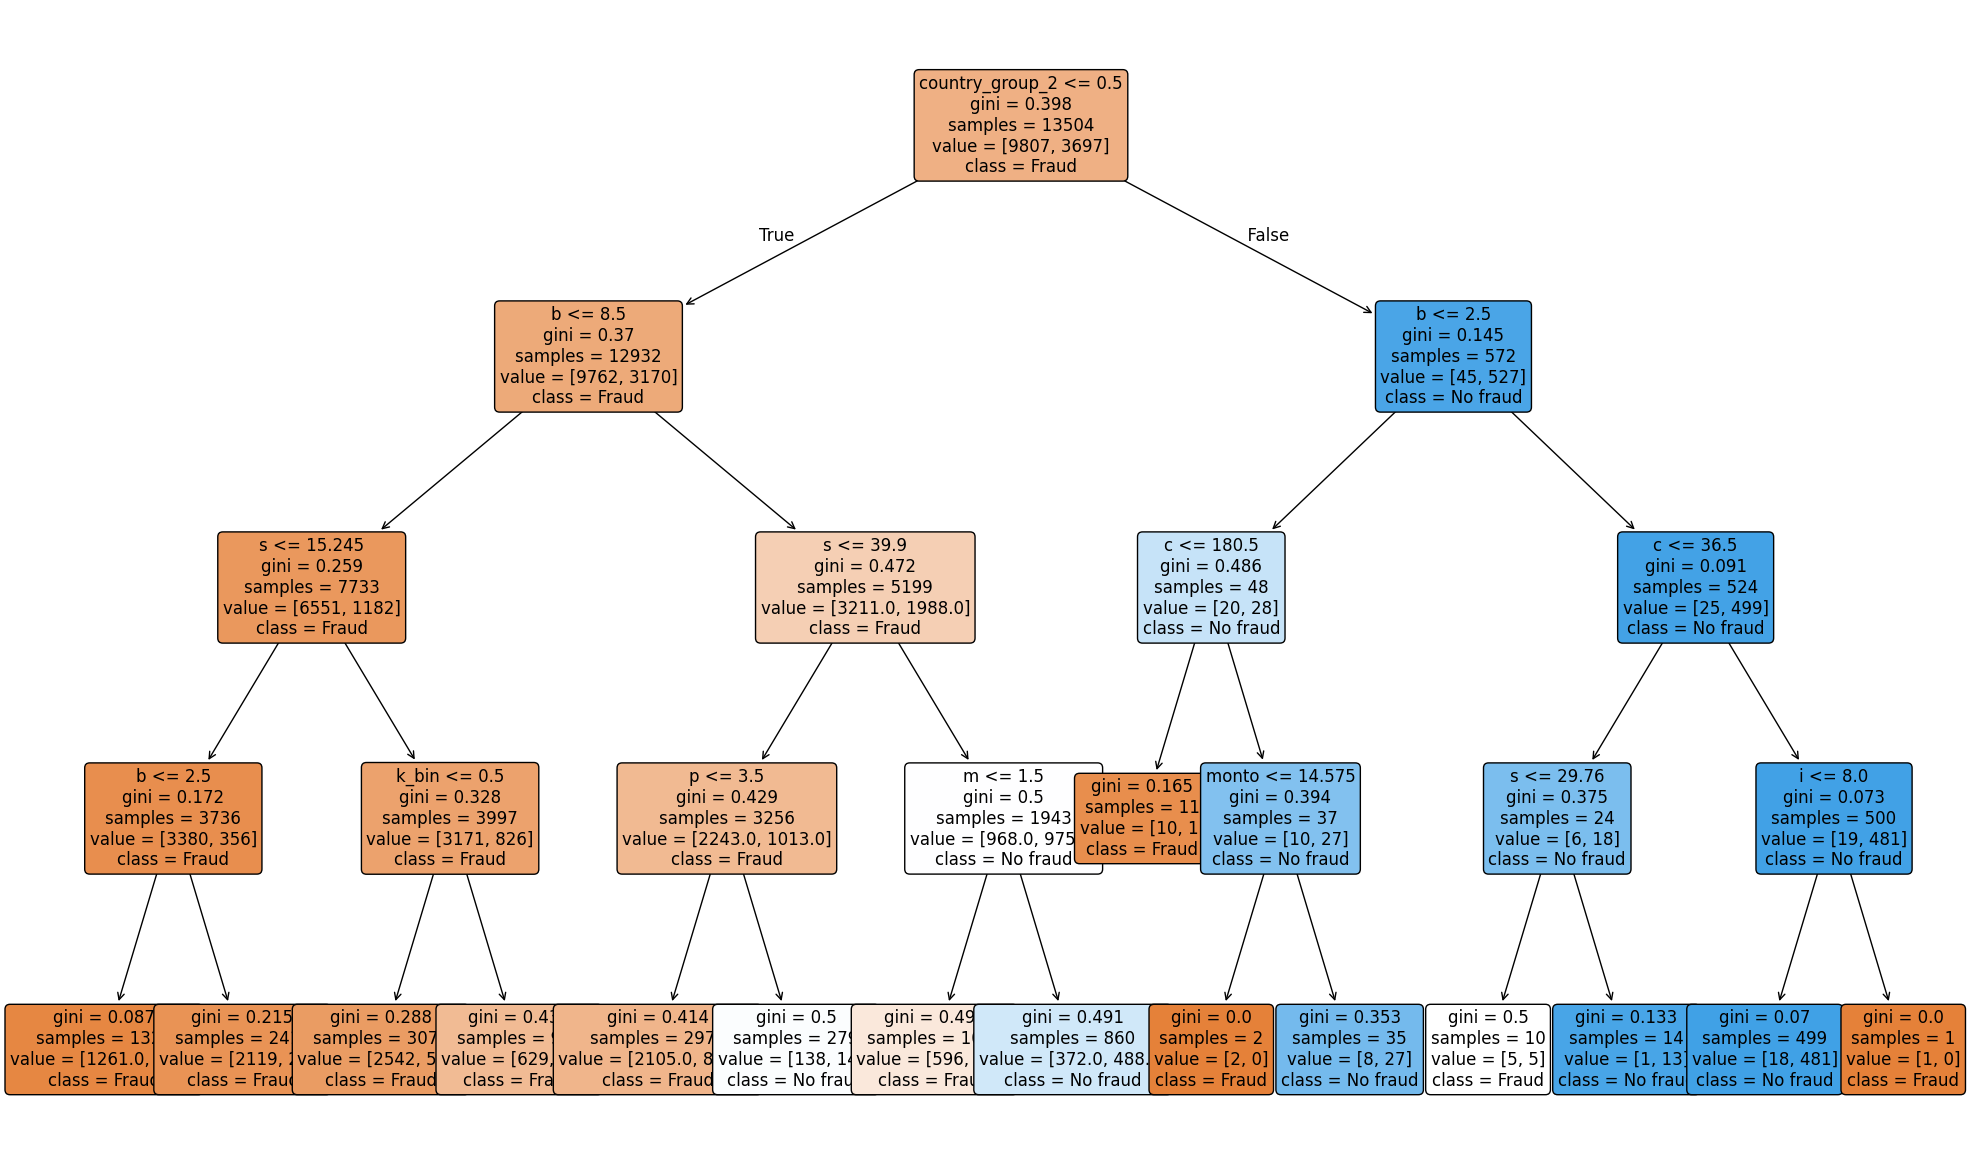

In [27]:
plt.figure(figsize=(25, 15))
plot_tree(tree,
          feature_names=predictors,
          class_names=['Fraud', 'No fraud'],
          rounded=True,
          filled=True,
          fontsize=12)

plt.show()

Esto es bastante interesante! Acá vemos que ya la variable `b` no es la que contiene el índice de gini más bajo, sino que es la variable `country_group_2`, la cual hace referencia al grupo dos de la variable country_group que creamos antes y se refiere a los países que aparecen con una frecuencia de entre 100 y 350 veces.

In [28]:
numerical_type_cols = df_full_train.select_dtypes(include=['float64', 'int64'])
del numerical_type_cols["fraude"]
mutual_info_num = df_full_train[numerical_type_cols.columns].apply(mutual_info_fraude_score)
mutual_info_num.sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

,0
monto,0.451164
c,0.385711
s,0.309927
b,0.051461
country_group_2,0.041974
country_group_3,0.038187
q,0.028718
p,0.010875
f,0.007950
m,0.007910


Acá vemos que las variables codificadas dieron un puntaje muy bueno que las ubicó entre el top 5 de variables con información más relacionada con el target.

Así pues, ya podemos pasar a escoger las variables que usaremos para nuestro modelo y graficaremos la matriz de correlación de Pearson para observar si existen relaciones fuertes entre ellas que puedan llevarnos a overfittings o errores. Esto es:

In [29]:
df_train.columns

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o',
       'p', 'q', 'r', 's', 'monto', 'k_bin', 'country_group_1',
       'country_group_2', 'country_group_3'],
      dtype='object')

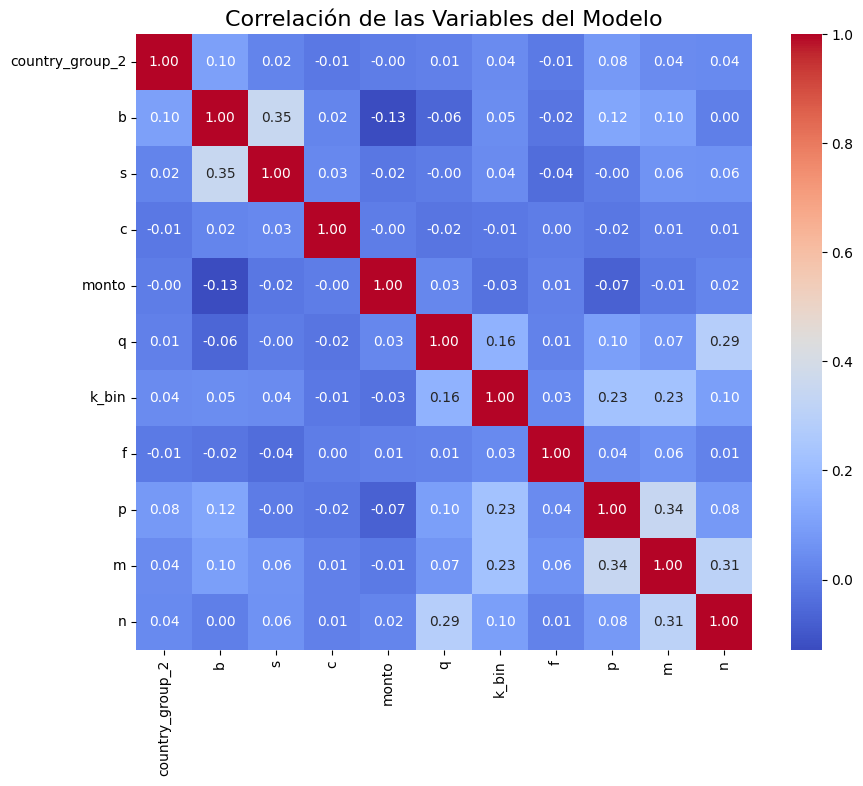

In [30]:
selected_columns = ["country_group_2", "b", "s", "c", "monto", "q", "k_bin", "f","p", "m", "n"]

df_selected = df_train[selected_columns]
corr_matrix = df_selected.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, annot=True, fmt=".2f")
plt.title('Correlación de las Variables del Modelo', fontsize=16)
plt.show()

Ahora, antes de aplicar el modelo debemos tener en cuenta algo muy muy importante: **la data está desbalanceada**. Con una proporción de aporximadamente $73 \%$ de lo que no es fraude y $27 \%$ de lo que sí es fraude, debemos tener cuidado con las métricas que nos resulten ya que esto influirá fuertemente en las predicciones que esté haciendo el modelo: si el modelo es muy bueno para predecir lo que no es fraude, pues no estaríamos haciendo nada, por lo que entonces usaremos una estrategia muy usada en estos casos, la cual consiste en realizar **Resampling de los datos**.

Los resamplings son muy usados en casos de fraude. El uso de Oversampling y UnderSampling depende mucho del contexto del problema, **sin embargo**, para los casos de fraude y de clasificación en general, el oversampling no es recomendado ya que éste requiere técnicas avanzadas de sintetización de datos y si tenemos en cuenta que no contamos con mucho contexto (aparte del numérico que es muy importante pero podría no ser suficiente) sobre la información que tienen cada una de las variables del dataset , es mejor no usar esta técnica y más bien usar el UnderSampling, donde tomamos una muestra de la clase mayoritaria (`0: No fraude`) y la igualamos con la clase minoritaria, sin necesidad de la creación de datos.

Esto es:



### **Un modelo con Resampling (UnderSampling)**

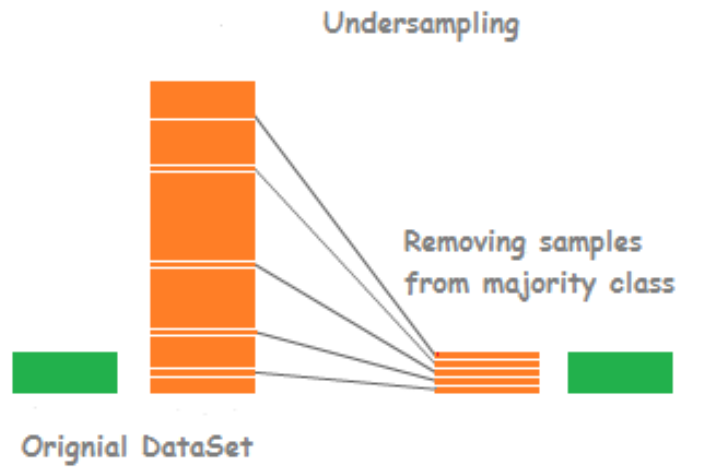

Entonces ahora armamos nuestros dataframes de entrenamiento, validación y testeo con las columnas seleccionadas:

In [31]:
X_train = df_train[selected_columns]
X_test = df_test[selected_columns]
X_val = df_val[selected_columns]

Realizamos UnderSampling. ¿Cómo?:

In [32]:
y_train_series = pd.Series(y_train)

undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=1)
X_train_undersample, y_train_undersample = undersample.fit_resample(X_train, y_train_series)

In [33]:
len(X_train_undersample)

6756

El parámetro más importante del código que se muestra arriba es el `sampling_strategy=0.8`: este especifica cómo será la estrategia de muestreo. Aquí, el valor de $0.7$ nos dice que el número de ejemplos de la clase minoritaria será el $70 \%$ del número de ejemplos de la clase mayoritaria después de aplicar el undersampling. En otras palabras, el número de ejemplos de la clase minoritaria se multiplicará por $0.7$ para establecer el número de ejemplos de la clase mayoritaria a muestrear.

Vemos que el tamaño de la muestra que extrajimos de la data de entrenamiento es de $6259$, lo cual es un numero lo suficientemente significativo para la implementación de modelos robustos de clasificación.

In [34]:
X_train_undersample.head()

,country_group_2,b,s,c,monto,q,k_bin,f,p,m,n
5996,0.0,-0.136979,-0.581639,-0.003576,-0.436593,-0.112333,1,-0.157313,-0.566837,-0.536118,-0.227047
3493,0.0,-1.205300,-1.030386,-0.478009,-0.483596,-0.112333,0,-0.157313,-0.566837,0.453278,-0.227047
2665,0.0,-0.777971,0.101367,-0.424572,-0.464937,-0.112333,1,-0.157313,1.206695,0.453278,-0.227047
3217,0.0,-0.136979,0.716482,4.938233,-0.106289,-0.112333,0,-0.157313,-0.566837,-0.536118,-0.227047
5834,0.0,-1.418964,0.593385,-0.153420,-0.219168,-0.112333,1,-0.072908,0.319929,-0.536118,-0.227047


**********Scores y resultados para XGBoost Data de Validación**********
Accuracy: 0.67
Precision: 0.44
Recall: 0.78
F1 Score: 0.56
**********Scores y resultados para XGBoost Data de Testeo**********
Accuracy: 0.69
Precision: 0.45
Recall: 0.74
F1 Score: 0.56


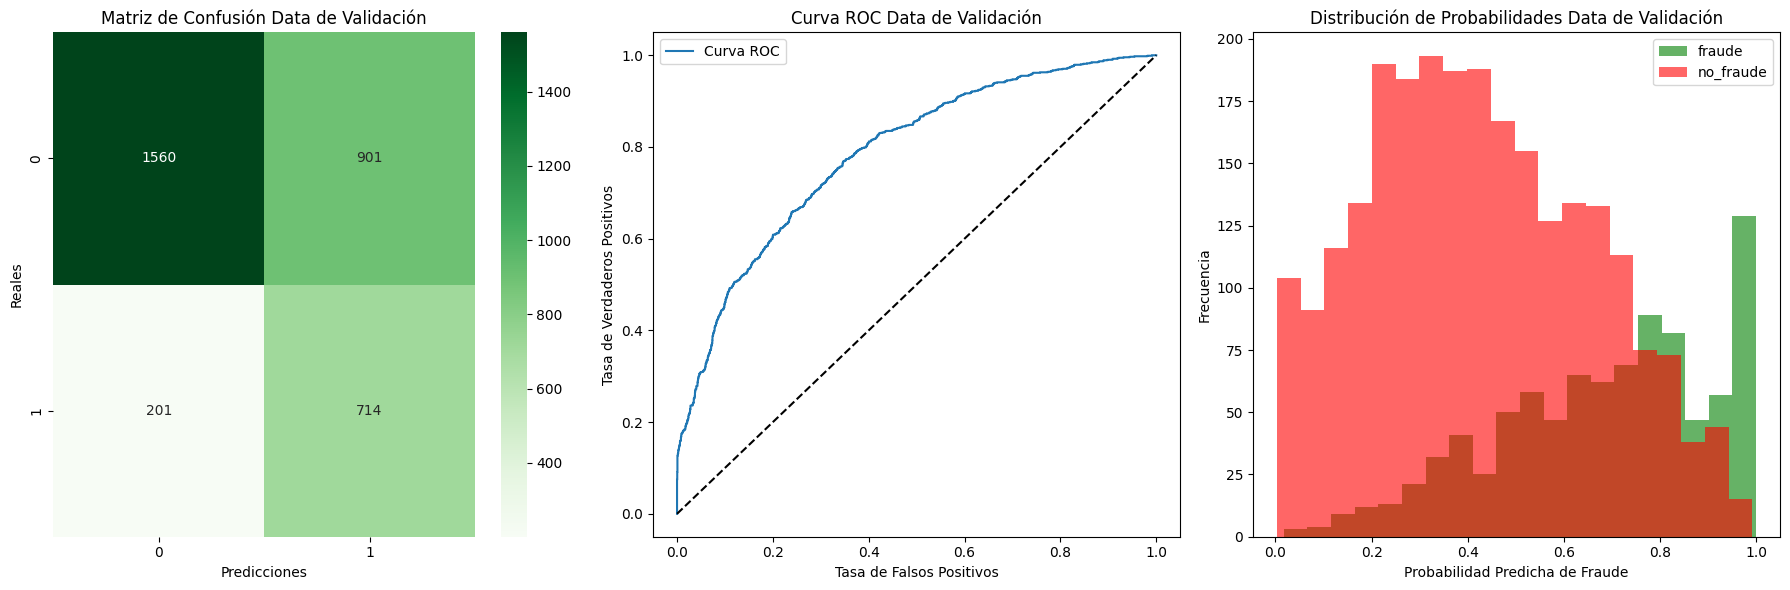

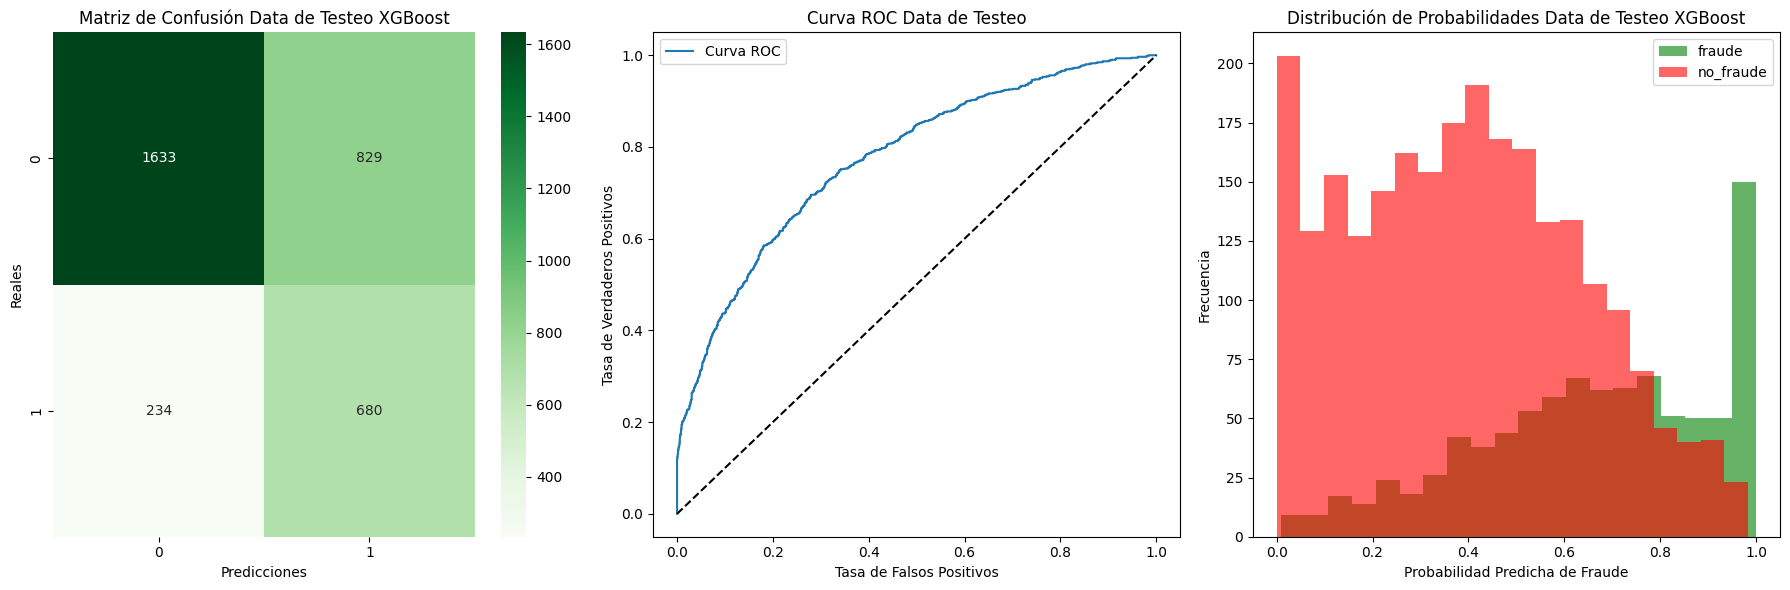

In [35]:
# @title **Modelo con UnderSampling con XGBoost**

# --------- Initializing XGBoost Model ---------
model_xgboost = xgb.XGBClassifier(n_estimators=250, random_state=42, scale_pos_weight=2.33, learning_rate = 0.1
                                  , max_depth = 4)

# Fit the model on undersampled training data
model_xgboost.fit(X_train_undersample, y_train_undersample)

# Predict class labels for validation and test sets
y_pred_xgboost_classes = model_xgboost.predict(X_val)
y_pred_xgboost_test_classes = model_xgboost.predict(X_test)

# --------- Scores and Results ---------
print("**********Scores y resultados para XGBoost Data de Validación**********")
accuracy = accuracy_score(y_val, y_pred_xgboost_classes)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, y_pred_xgboost_classes)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, y_pred_xgboost_classes)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, y_pred_xgboost_classes)
print(f'F1 Score: {f1:.2f}')

print("**********Scores y resultados para XGBoost Data de Testeo**********")
accuracy = accuracy_score(y_test, y_pred_xgboost_test_classes)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_test, y_pred_xgboost_test_classes)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_test, y_pred_xgboost_test_classes)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_test, y_pred_xgboost_test_classes)
print(f'F1 Score: {f1:.2f}')


# ---------- GRAFICAS PARA DATA DE VALIDACION ----------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred_xgboost_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title('Matriz de Confusión Data de Validación')
axs[0].set_xlabel('Predicciones')
axs[0].set_ylabel('Reales')

# Curva ROC (usando predict_proba para obtener probabilidades)
y_pred_xgboost_probs = model_xgboost.predict_proba(X_val)[:, 1]  # Obtener las probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgboost_probs)
axs[1].plot(fpr, tpr, label='Curva ROC')
axs[1].plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
axs[1].set_title('Curva ROC Data de Validación')
axs[1].set_xlabel('Tasa de Falsos Positivos')
axs[1].set_ylabel('Tasa de Verdaderos Positivos')
axs[1].legend(loc='best')

# Histograma de probabilidades
fraude = y_pred_xgboost_probs[y_val == 1]
no_fraude = y_pred_xgboost_probs[y_val == 0]
axs[2].hist(fraude, bins=20, alpha=0.6, color='g', label='fraude')
axs[2].hist(no_fraude, bins=20, alpha=0.6, color='r', label='no_fraude')
axs[2].set_title('Distribución de Probabilidades Data de Validación')
axs[2].set_xlabel('Probabilidad Predicha de Fraude')
axs[2].set_ylabel('Frecuencia')
axs[2].legend(loc='best')
plt.tight_layout()
plt.show()


# -------------- GRAFICAS PARA DATA DE TESTEO ------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_xgboost_test_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title('Matriz de Confusión Data de Testeo XGBoost')
axs[0].set_xlabel('Predicciones')
axs[0].set_ylabel('Reales')

# Curva ROC (usando predict_proba para obtener probabilidades)
y_pred_xgboost_test_probs = model_xgboost.predict_proba(X_test)[:, 1]  # Obtener las probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgboost_test_probs)
axs[1].plot(fpr, tpr, label='Curva ROC')
axs[1].plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
axs[1].set_title('Curva ROC Data de Testeo')
axs[1].set_xlabel('Tasa de Falsos Positivos')
axs[1].set_ylabel('Tasa de Verdaderos Positivos')
axs[1].legend(loc='best')

# Histograma de probabilidades
fraude = y_pred_xgboost_test_probs[y_test == 1]
no_fraude = y_pred_xgboost_test_probs[y_test == 0]
axs[2].hist(fraude, bins=20, alpha=0.6, color='g', label='fraude')
axs[2].hist(no_fraude, bins=20, alpha=0.6, color='r', label='no_fraude')
axs[2].set_title('Distribución de Probabilidades Data de Testeo XGBoost')
axs[2].set_xlabel('Probabilidad Predicha de Fraude')
axs[2].set_ylabel('Frecuencia')
axs[2].legend(loc='best')
plt.tight_layout()
plt.show()


**********Scores y resultados para Random Forest Data de Validación**********
Accuracy: 0.69
Precision: 0.45
Recall: 0.68
F1 Score: 0.54
**********Scores y resultados para Random Forest Data de Testeo**********
Accuracy: 0.70
Precision: 0.46
Recall: 0.70
F1 Score: 0.55


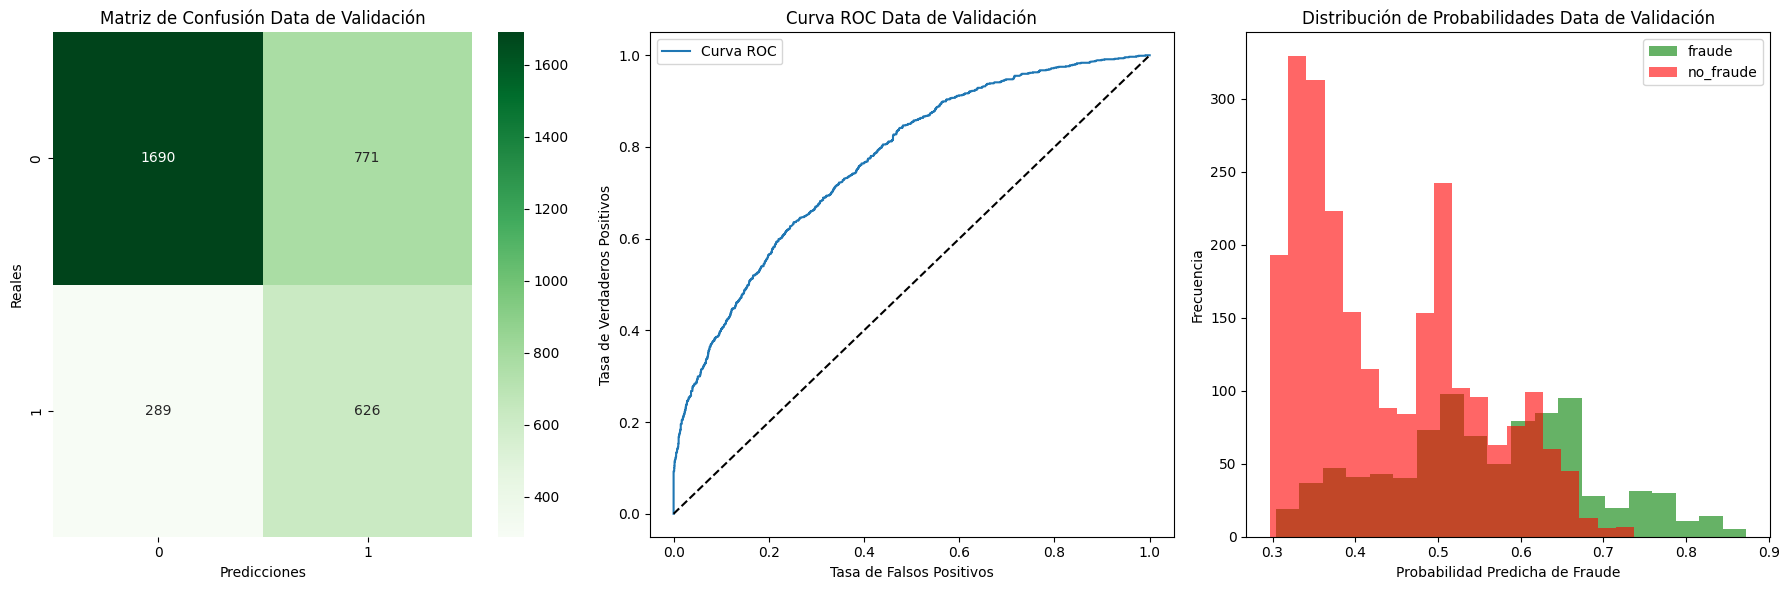

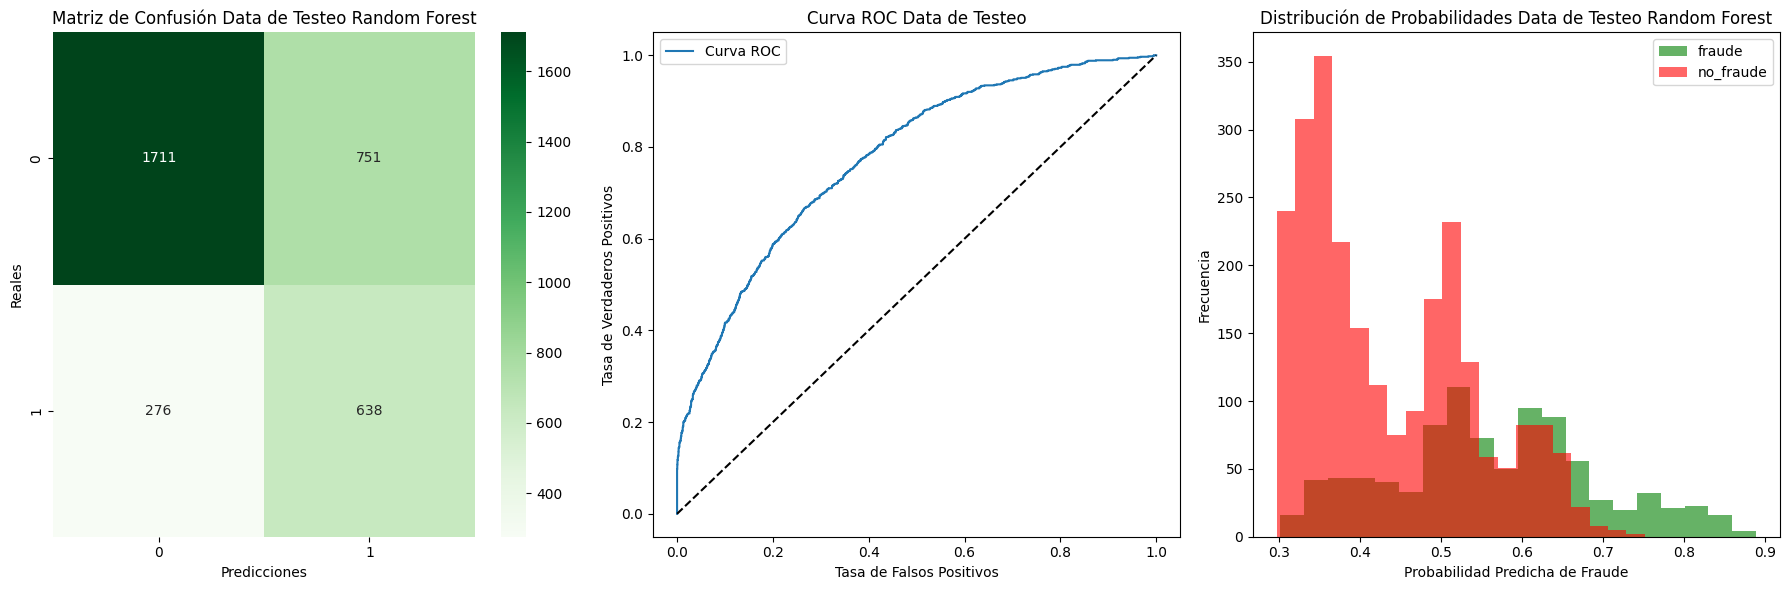

In [36]:
# @title **Modelo con UnderSampling con RandomForest**
class_weight={0: 1, 1:1.78}

# Crear y entrenar el modelo Random Forest
model_rf = RandomForestClassifier(
    n_estimators=250,
    random_state=42,
    class_weight="balanced",max_depth=3
)

# Fit the model on undersampled training data
model_rf.fit(X_train_undersample, y_train_undersample)

# Predict class labels for validation and test sets
y_pred_rf_classes = model_rf.predict(X_val)
y_pred_rf_test_classes = model_rf.predict(X_test)

# --------- Scores and Results ---------
print("**********Scores y resultados para Random Forest Data de Validación**********")
accuracy = accuracy_score(y_val, y_pred_rf_classes)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, y_pred_rf_classes)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, y_pred_rf_classes)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, y_pred_rf_classes)
print(f'F1 Score: {f1:.2f}')

print("**********Scores y resultados para Random Forest Data de Testeo**********")
accuracy = accuracy_score(y_test, y_pred_rf_test_classes)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_test, y_pred_rf_test_classes)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_test, y_pred_rf_test_classes)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_test, y_pred_rf_test_classes)
print(f'F1 Score: {f1:.2f}')


# ---------- GRAFICAS PARA DATA DE VALIDACION ----------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred_rf_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title('Matriz de Confusión Data de Validación')
axs[0].set_xlabel('Predicciones')
axs[0].set_ylabel('Reales')

# Curva ROC (usando predict_proba para obtener probabilidades)
y_pred_rf_probs = model_rf.predict_proba(X_val)[:, 1]  # Obtener las probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf_probs)
axs[1].plot(fpr, tpr, label='Curva ROC')
axs[1].plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
axs[1].set_title('Curva ROC Data de Validación')
axs[1].set_xlabel('Tasa de Falsos Positivos')
axs[1].set_ylabel('Tasa de Verdaderos Positivos')
axs[1].legend(loc='best')

# Histograma de probabilidades
fraude = y_pred_rf_probs[y_val == 1]
no_fraude = y_pred_rf_probs[y_val == 0]
axs[2].hist(fraude, bins=20, alpha=0.6, color='g', label='fraude')
axs[2].hist(no_fraude, bins=20, alpha=0.6, color='r', label='no_fraude')
axs[2].set_title('Distribución de Probabilidades Data de Validación')
axs[2].set_xlabel('Probabilidad Predicha de Fraude')
axs[2].set_ylabel('Frecuencia')
axs[2].legend(loc='best')
plt.tight_layout()
plt.show()


# -------------- GRAFICAS PARA DATA DE TESTEO ------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf_test_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title('Matriz de Confusión Data de Testeo Random Forest')
axs[0].set_xlabel('Predicciones')
axs[0].set_ylabel('Reales')

# Curva ROC (usando predict_proba para obtener probabilidades)
y_pred_rf_test_probs = model_rf.predict_proba(X_test)[:, 1]  # Obtener las probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_test_probs)
axs[1].plot(fpr, tpr, label='Curva ROC')
axs[1].plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
axs[1].set_title('Curva ROC Data de Testeo')
axs[1].set_xlabel('Tasa de Falsos Positivos')
axs[1].set_ylabel('Tasa de Verdaderos Positivos')
axs[1].legend(loc='best')

# Histograma de probabilidades
fraude = y_pred_rf_test_probs[y_test == 1]
no_fraude = y_pred_rf_test_probs[y_test == 0]
axs[2].hist(fraude, bins=20, alpha=0.6, color='g', label='fraude')
axs[2].hist(no_fraude, bins=20, alpha=0.6, color='r', label='no_fraude')
axs[2].set_title('Distribución de Probabilidades Data de Testeo Random Forest')
axs[2].set_xlabel('Probabilidad Predicha de Fraude')
axs[2].set_ylabel('Frecuencia')
axs[2].legend(loc='best')
plt.tight_layout()
plt.show()


**********Scores y resultados para Decision Tree Data de Validación**********
Accuracy: 0.62
Precision: 0.40
Recall: 0.79
F1 Score: 0.53
**********Scores y resultados para Decision Tree Data de Testeo**********
Accuracy: 0.63
Precision: 0.40
Recall: 0.81
F1 Score: 0.54


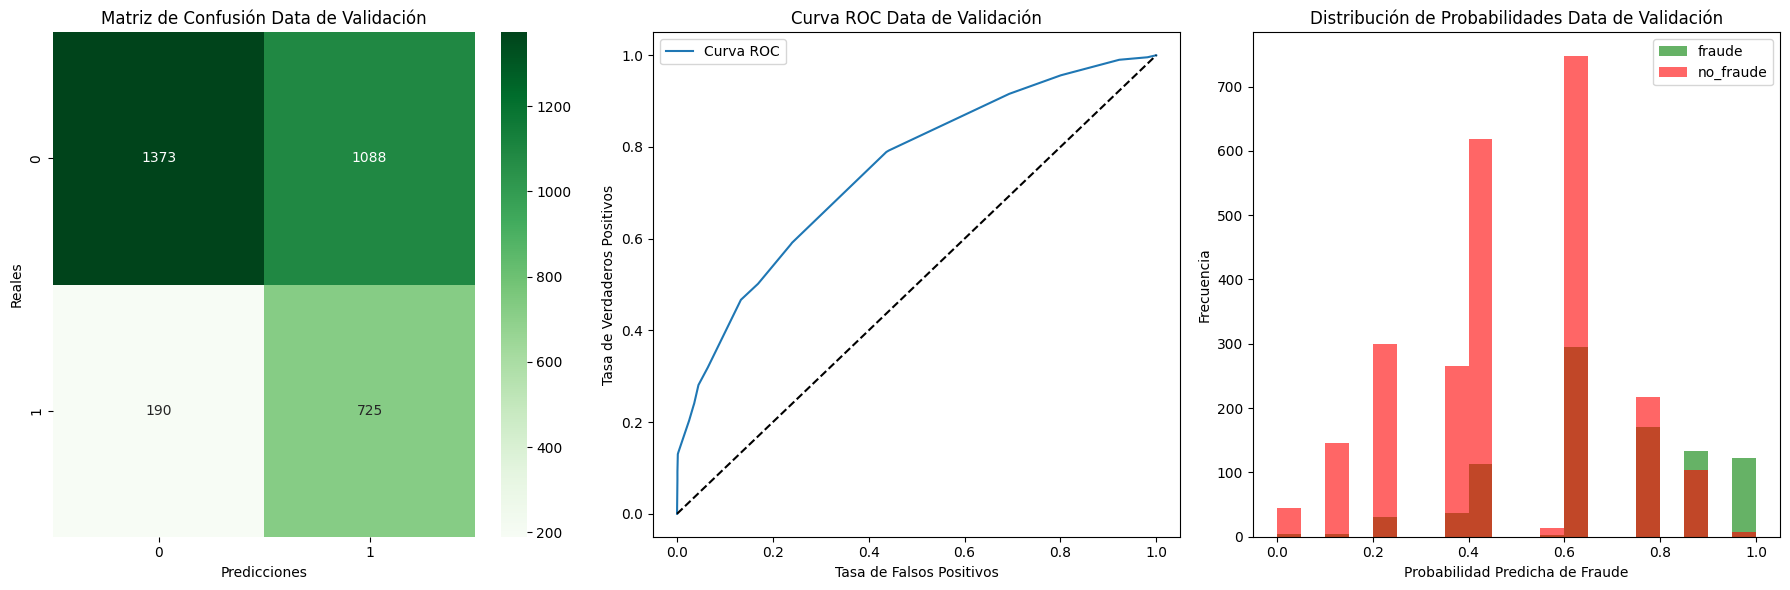

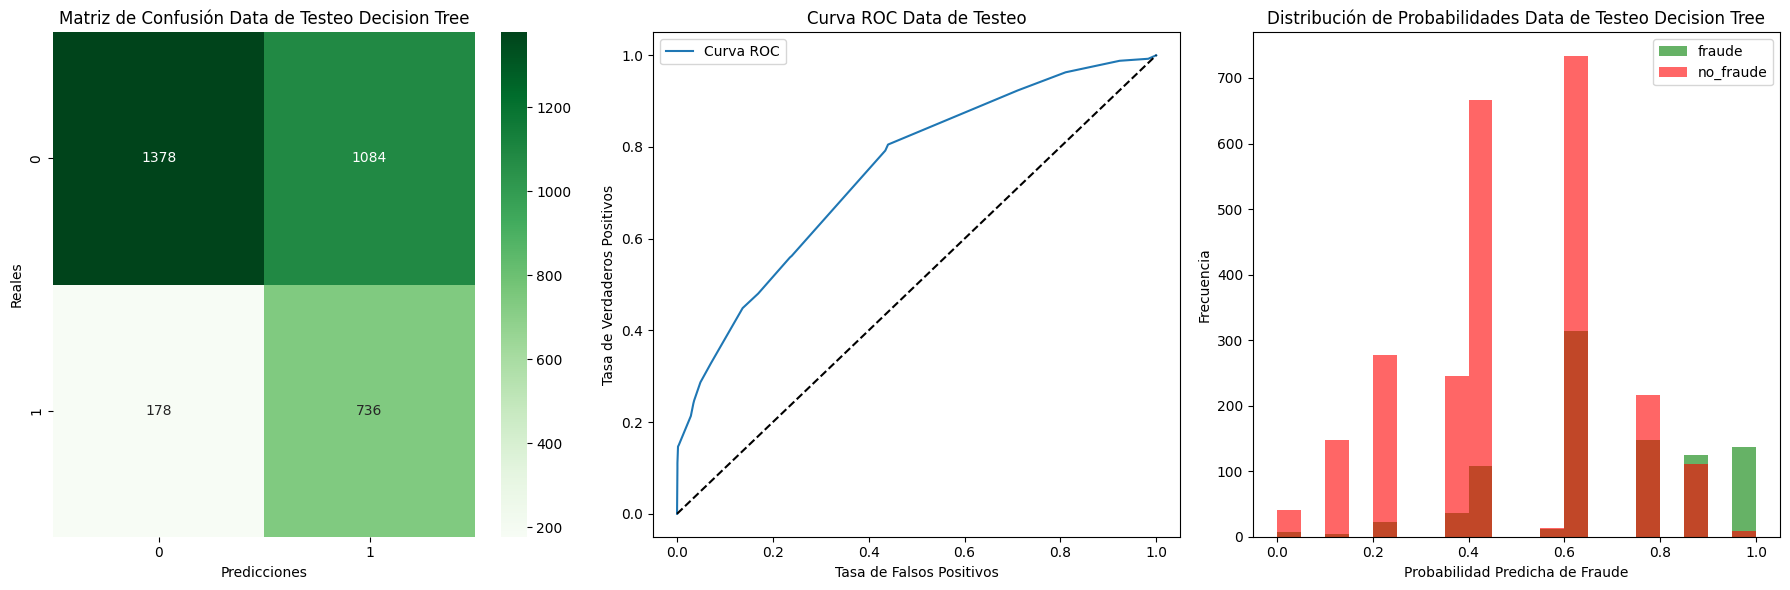

In [40]:
# @title **Modelo con UnderSampling con Árboles de decisión**

class_weight = {0:1, 1:2.2}
model_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    random_state=42,
    class_weight=class_weight
)

model_dt.fit(X_train_undersample, y_train_undersample)

y_pred_dt_classes = model_dt.predict(X_val)
y_pred_dt_test_classes = model_dt.predict(X_test)

# --------- Scores and Results ---------
print("**********Scores y resultados para Decision Tree Data de Validación**********")
accuracy = accuracy_score(y_val, y_pred_dt_classes)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, y_pred_dt_classes)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, y_pred_dt_classes)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, y_pred_dt_classes)
print(f'F1 Score: {f1:.2f}')

print("**********Scores y resultados para Decision Tree Data de Testeo**********")
accuracy = accuracy_score(y_test, y_pred_dt_test_classes)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_test, y_pred_dt_test_classes)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_test, y_pred_dt_test_classes)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_test, y_pred_dt_test_classes)
print(f'F1 Score: {f1:.2f}')


# ---------- GRAFICAS PARA DATA DE VALIDACION ----------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred_dt_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title('Matriz de Confusión Data de Validación')
axs[0].set_xlabel('Predicciones')
axs[0].set_ylabel('Reales')

# Curva ROC (usando predict_proba para obtener probabilidades)
y_pred_dt_probs = model_dt.predict_proba(X_val)[:, 1]  # Obtener las probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_pred_dt_probs)
axs[1].plot(fpr, tpr, label='Curva ROC')
axs[1].plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
axs[1].set_title('Curva ROC Data de Validación')
axs[1].set_xlabel('Tasa de Falsos Positivos')
axs[1].set_ylabel('Tasa de Verdaderos Positivos')
axs[1].legend(loc='best')

# Histograma de probabilidades
fraude = y_pred_dt_probs[y_val == 1]
no_fraude = y_pred_dt_probs[y_val == 0]
axs[2].hist(fraude, bins=20, alpha=0.6, color='g', label='fraude')
axs[2].hist(no_fraude, bins=20, alpha=0.6, color='r', label='no_fraude')
axs[2].set_title('Distribución de Probabilidades Data de Validación')
axs[2].set_xlabel('Probabilidad Predicha de Fraude')
axs[2].set_ylabel('Frecuencia')
axs[2].legend(loc='best')
plt.tight_layout()
plt.show()


# -------------- GRAFICAS PARA DATA DE TESTEO ------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_dt_test_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title('Matriz de Confusión Data de Testeo Decision Tree')
axs[0].set_xlabel('Predicciones')
axs[0].set_ylabel('Reales')

# Curva ROC (usando predict_proba para obtener probabilidades)
y_pred_dt_test_probs = model_dt.predict_proba(X_test)[:, 1]  # Obtener las probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt_test_probs)
axs[1].plot(fpr, tpr, label='Curva ROC')
axs[1].plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
axs[1].set_title('Curva ROC Data de Testeo')
axs[1].set_xlabel('Tasa de Falsos Positivos')
axs[1].set_ylabel('Tasa de Verdaderos Positivos')
axs[1].legend(loc='best')

# Histograma de probabilidades
fraude = y_pred_dt_test_probs[y_test == 1]
no_fraude = y_pred_dt_test_probs[y_test == 0]
axs[2].hist(fraude, bins=20, alpha=0.6, color='g', label='fraude')
axs[2].hist(no_fraude, bins=20, alpha=0.6, color='r', label='no_fraude')
axs[2].set_title('Distribución de Probabilidades Data de Testeo Decision Tree')
axs[2].set_xlabel('Probabilidad Predicha de Fraude')
axs[2].set_ylabel('Frecuencia')
axs[2].legend(loc='best')
plt.tight_layout()
plt.show()


En este problema de clasificación se probaron todos los métodos de clasificación binaria aprendidos durante el curso de Machine Learning para identificar el que mejor funcionara. El "mejor" modelo en este caso no solo debía ser capaz de identificar correctamente las transacciones fraudulentas, sino también de minimizar los errores al clasificar transacciones legítimas como fraudulentas.

Es importante entender el contexto: si Mercado Libre clasifica erróneamente una transacción legítima como fraudulenta, esto puede generar descontento y desconfianza por parte de los usuarios, lo cual afecta negativamente la reputación de la empresa y puede traducirse en pérdidas económicas. Por lo tanto, aunque es fundamental identificar tantas transacciones fraudulentas como sea posible, no se debe priorizar excesivamente una métrica como el recall, ya que esto podría aumentar los falsos positivos (transacciones legítimas clasificadas erróneamente como fraude).

En lugar de enfocarse solo en recall, se buscó un equilibrio en el modelo. En este caso quisimos lograr un **recall** significativamente más alto que el **precision**, pero sin llegar a un punto donde el modelo comience a clasificar demasiadas transacciones no fraudulentas como fraude. Este enfoque busca un balance adecuado entre ambas métricas, priorizando la detección de fraude mientras se minimizan los efectos negativos en las transacciones legítimas.

---

**TABLA DE MODELOS Y MÉTRICAS QUE SE PROBRARON**

Con el fin de encontrar el mejor modelo que se adaptara al contexto del problema, varios clasificadores de los dictados en el curso fueron probados, sin embargo para que el código no quedara tan largo, fueron probados y los resultados de las métricas más importantes para este caso, el **Recall y el F1-Score**, fueron calculados y documentados acá:

**Modelo con Undersampling:** El orden en que aparecen los números es Recall- F1-Score

| Modelo | Testeo | Validación |
|--------|--------|------------|
|RF|**0.70-0.55**|**0.68-0.54**|
|GB|0.54-0.54|0.60-0.55|
|AB|0.47-0.52|0.52-0.54|
|XGB|**0.74-0.56**|**0.78-0.56**|
|DT|**0.81-0.54**|**0.79-0.53**|

Teniendo esta en cuenta, para el producto final nos quedamos con tres modelos: **XGBoost, Random Forest y Árboles de decisión** ya que si observamos los resultados de las métricas recall y f1-score con el modelo con undersampling para estos tres, vemos que se obtuvieron los mejores resultados. Sin embargo estos no fueron escogidos simplemente por un alto score en las métricas mencionadas sino más bien por los **resultados que nos generaba la matríz de confusión**.

Si observamos los resultados del modelo con **XGBoost**, vemos que su matriz de confusión (para la data de testeo) tiene la siguiente forma:

$$CM_{XGB} = \begin{pmatrix}  1633 & 829 \\ 234 & 680 \end{pmatrix}$$

La de **Random Forest** (tambén para la data de testeo):

$$CM_{RF} = \begin{pmatrix}  1711 & 751 \\ 276 & 638 \end{pmatrix}$$

Y la de **Árboles de decisión** (también para data de testeo):

$$CM_{DT} = \begin{pmatrix}  1378 & 1084 \\ 178 & 736  \end{pmatrix}$$

El modelo con XGB logra un mejor equilibrio entre la detección de fraudes reales (mayor cantidad de verdaderos positivos) y una reducción de los falsos negativos. Aunque, el modelo aún clasifica un número considerable de transacciones legítimas como fraude (829 falsos positivos), cais no se equivoca en decir qué transacciones son fraude realmente (solo en 201). Si analizamos el histograma de probabilidades, observamos que no existe un umbral claro que permita separar con precisión las transacciones fraudulentas de las legítimas. Esto puede explicar por qué el modelo envía varias transacciones legítimas a la categoría de fraude. A pesar de este inconveniente, XGBoost muestra un rendimiento superior al priorizar el recall, lo que resulta crucial para el contexto de detección de fraudes, aunque no elimina completamente el problema de falsos positivos.


El modelo de Random Forest (RF) muestra un equilibrio notablemente mejor en comparación con otros modelos. Aunque, al igual que en todos los casos, predice más eficazmente las transacciones que no son fraude, también logra una proporción aceptable de aciertos en la detección de fraudes. Con un recall de $0.70$, no se aleja demasiado de los resultados de XGBoost, pero tiene como desventaja la generación de equivocarse más en decir qué es fraude. Al analizar el histograma de probabilidades, se puede identificar un umbral claro alrededor de $0.65$, donde todas las transacciones hacia la derecha corresponden claramente a fraudes. Esta claridad es una gran ventaja en comparación con XGBoost. **Sin embargo**, como mencionamos antes, aunque este modelo logra una división más definida entre las transacciones legítimas y fraudulentas, al observar su matriz de confusión y compararla con la de XGBoost, queda claro que el rendimiento en la predicción de fraudes es significativamente inferior. Si bien el equilibrio es deseable, nuestra prioridad es maximizar el recall para detectar fraudes reales. Por tanto, este modelo no sería la mejor opción para implementarlo en producción, ya que sacrifica demasiados casos de fraude en su búsqueda de equilibrio.

El modelo de DT tiene una alta precisión al identificar las transacciones que son fraudulentas, pero gracias a que está priorizando demasiado el recall, está enviando muchas transacciones no fraudulentas a fraude (1084). No obstante, esto no significa que el modelo sea completamente ineficaz. Si observamos el histograma de probabilidades, podemos ver que el modelo intenta encontrar el umbral adecuado para distinguir entre transacciones fraudulentas y no fraudulentas.

**Así pues, la decisión final para el despliegue del modelo con Docker y FastAPI se hará con XGBoost, debido a que despues de realizar la evaluación de varios hiperparámetros, la matriz de confusión nos da mejores resultados que los otros dos modelos.**